In [2]:
"""
居民和商铺分开分析
"""
import pandas as pd
import numpy as np
from pyecharts import options as opts
from pyecharts.charts import Page, Pie
import pymysql
from datetime import datetime,timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker


def get_data_from_database(db_table_name):
    con = pymysql.connect(host = "localhost", 
               user = "root", password = '180153', 
               db = "epidemic", charset='utf8')

    sql = "select cons_no,this_pq,trade_code,ds from " + db_table_name + " where cons_no is not null and ds like '2021%'"
    df = pd.read_sql(sql, con)
    con.close()
    df["this_pq"] = df["this_pq"].apply(lambda x: float(x))
    userid = list(set(df['cons_no']))
    print('该小区2021年一共有{0}户'.format(len(userid)))
    return df, userid


db_table_name = "ga_daypq_suqian_city_zhonghua_analysis"
df, userid = get_data_from_database(db_table_name)
df.index =  df["ds"].map(lambda date: parse(str(date)))
# 选取数据两类，分别是商铺和居民
df_resident = df.loc[df["trade_code"] == "城镇居民"]
df_retail = df.loc[df["trade_code"] != "城镇居民"]

该小区2021年一共有356户


In [3]:
def get_information(index, df):
    '''
    得到用户数量number_index，负荷load_day, 空置率hvr_day.
    '''
    number_day = []
    load_day = []
    hvr_day = []
    for day in index:
        data_day = df.loc[day]
        # userid = list(set(df['cons_no']))
        load_day.append(data_day["this_pq"].sum())
        number_day.append(sum(data_day["this_pq"] > 0.9))
        hvr_day.append(1 - sum(data_day["this_pq"] > 0.9)/len(data_day))
    return number_day, load_day, hvr_day



index = pd.date_range('20210701','20210728',freq='D')
number_retail, load_retail, hvr_retail = get_information(index, df_retail)
number_resident, load_resident, hvr_resident = get_information(index, df_resident)

[6556.31,
 6540.58,
 5666.99,
 6257.120000000001,
 5055.58,
 5152.3,
 5112.81,
 5868.120000000001,
 6262.01,
 6662.12,
 7116.93,
 6822.4,
 6627.16,
 7049.31,
 6617.94,
 4766.1,
 5619.341399999999,
 6366.725,
 6273.389999999999,
 6544.56,
 6390.009999999999,
 3453.8900000000003,
 2315.04,
 2231.39,
 2098.3,
 1983.1,
 1692.45,
 1432.8600000000001]

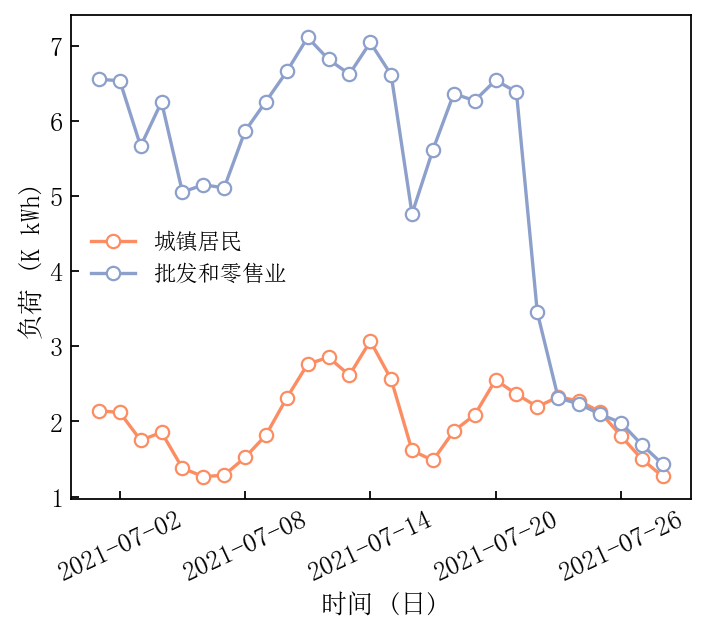

In [8]:
plt.figure(dpi = 160,figsize=(5,4))
config = {
    "font.family":"serif",    #serif
    "font.size": 12,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
    "xtick.direction": "in",
    "ytick.direction": "in",
}

rcParams.update(config)
colors=plt.cm.get_cmap('Set2')(range(5))
plt.xticks(rotation=25)
plt.xlabel("时间 (日)")
plt.ylabel("负荷 (K kWh)")
plt.plot(index, np.array(load_resident)/1000, color=colors[1], marker= "o", mfc='w')
plt.plot(index, np.array(load_retail)/1000, color=colors[2], marker= "o", mfc='w')

ax = plt.gca()
tick_spacing = 6      #通过修改tick_spacing的值可以修改x轴的密度
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))
plt.legend(["城镇居民","批发和零售业"],loc='best',fontsize="small",frameon=False)
#print(np.array(load_day)/1000)
#print(hvr_day)
#print(number_day)、
load_retail

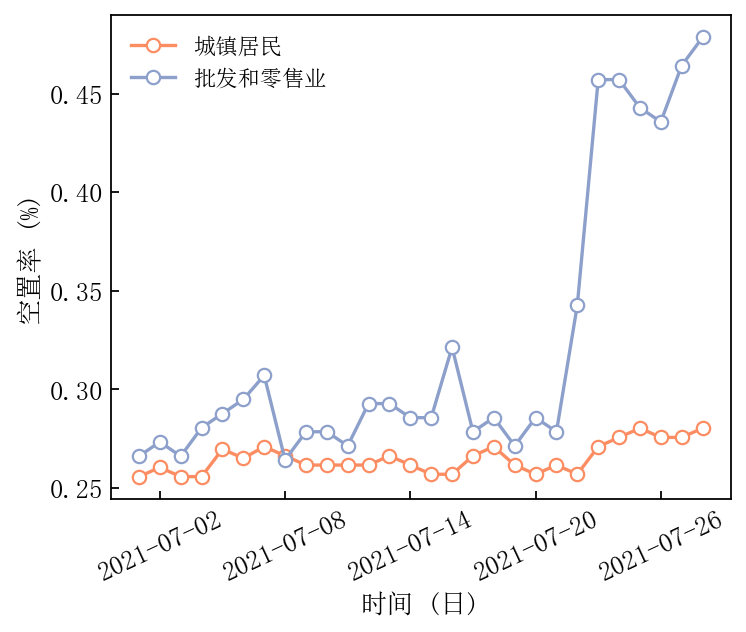

In [9]:
plt.figure(dpi = 160,figsize=(5,4))
config = {
    "font.family":"serif",    #serif
    "font.size": 12,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
    "xtick.direction": "in",
    "ytick.direction": "in",
}

rcParams.update(config)
colors=plt.cm.get_cmap('Set2')(range(5))
plt.xticks(rotation=25)
plt.xlabel("时间 (日)")
plt.ylabel("空置率 (%)")
plt.plot(index, np.array(hvr_resident), color=colors[1], marker= "o", mfc='w')
plt.plot(index, np.array(hvr_retail), color=colors[2], marker= "o", mfc='w')

ax = plt.gca()
tick_spacing = 6      #通过修改tick_spacing的值可以修改x轴的密度
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))
plt.legend(["城镇居民","批发和零售业"],loc='best',fontsize="small",frameon=False)

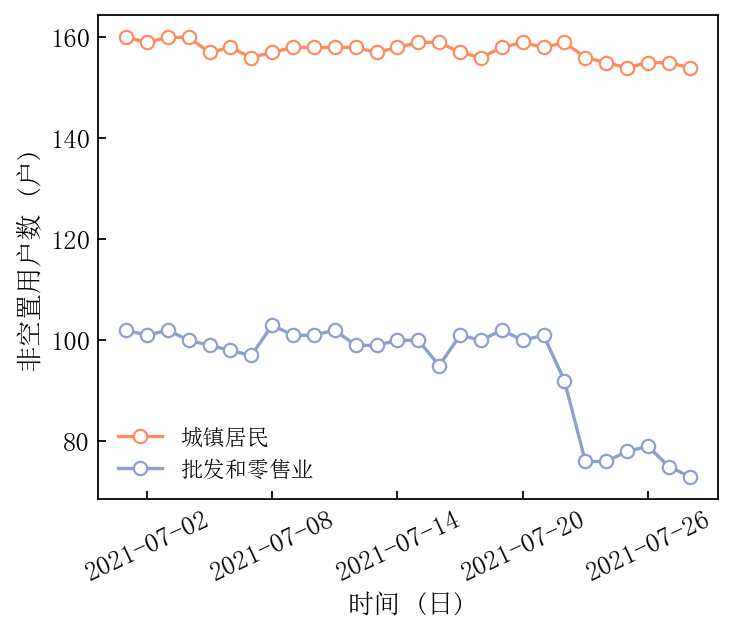

In [10]:
plt.figure(dpi = 160,figsize=(5,4))
config = {
    "font.family":"serif",    #serif
    "font.size": 12,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
    "xtick.direction": "in",
    "ytick.direction": "in",
}

rcParams.update(config)
colors=plt.cm.get_cmap('Set2')(range(5))
plt.xticks(rotation=25)
plt.xlabel("时间 (日)")
plt.ylabel("非空置用户数 (户)")
plt.plot(index, np.array(number_resident), color=colors[1], marker= "o", mfc='w')
plt.plot(index, np.array(number_retail), color=colors[2], marker= "o", mfc='w')

ax = plt.gca()
tick_spacing = 6      #通过修改tick_spacing的值可以修改x轴的密度
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))
plt.legend(["城镇居民","批发和零售业"],loc='best',fontsize="small",frameon=False)

In [29]:
def get_stat_change_inf(df, crisis):
    data_crisis = df.loc[crisis]
    userid = list(set(data_crisis['cons_no']))
    inout = {date:([],[]) for date in crisis}

    #根据change_stat划分用户
    all_unused = []
    all_used = []

    for uid in userid:
        data_uid = data_crisis.loc[data_crisis["cons_no"] == uid]
        change_stat = False
        num = 1

        for day in crisis:
            data_uid_day = data_uid.loc[day]
            if num == 1: 
                past_stat = data_uid_day["this_pq"] > 0.9
                num += 1
            else:
                now_stat = data_uid_day["this_pq"] > 0.9
                # 流出
                if  now_stat == False and past_stat == True:
                    inout[day][1].append(uid)
                    change_stat = True
                # 流入
                elif now_stat == True and past_stat == False:
                    inout[day][0].append(uid)
                    change_stat = True
                # 更新状态
                past_stat = now_stat

        # 一直在家
        if change_stat == False and now_stat == True:
            all_used.append(uid)
        # 一直不在家
        elif change_stat == False and now_stat == False:
            all_unused.append(uid)
    return all_unused, all_used, inout


# 流入流出情况统计 7月22号前后开始出现异常,出现疫情
# 分析疫情前后的流入流出状况,前后7天
crisis = pd.date_range('20210715', '20210728', freq='D')
all_unused_resident, all_used_resident, inout_resident = get_stat_change_inf(df_resident, crisis)
all_unused_retail, all_used_retail, inout_retail = get_stat_change_inf(df_retail, crisis)

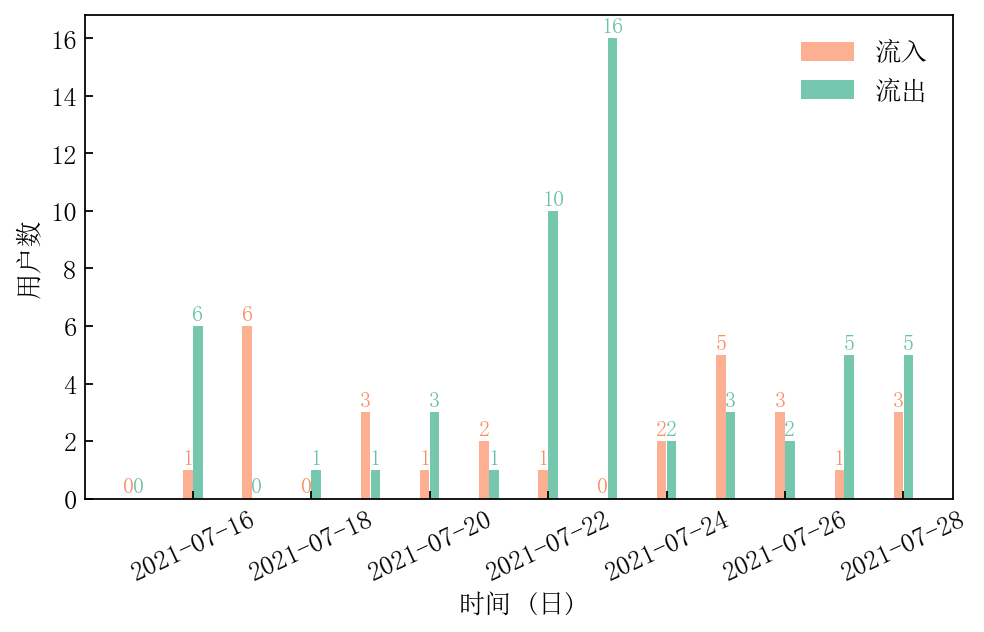

In [36]:
v2l_num = []
l2v_num = []
for key,(v2l, l2v) in inout_retail.items():
    v2l_num.append(len(v2l))
    l2v_num.append(len(l2v))

config = {
    "font.family":"serif",    #serif
    "font.size": 12,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
    "xtick.direction": "in",
    "ytick.direction": "in",
}
rcParams.update(config)

plt.figure(dpi=160,figsize=(7,4))
bar_width = 0.16 # 设置柱状图的宽度

bar1 = plt.bar(crisis - timedelta(hours=2),  v2l_num, bar_width, color =  plt.cm.get_cmap('Set2')(range(5))[1], alpha=0.7, label="流入")

for a,b,c in zip((crisis - timedelta(hours=2)),v2l_num, v2l_num): ##控制标签位置
    plt.text(a, b+0.1, c, ha='center', va='bottom', fontsize=10, color= plt.cm.get_cmap('Set2')(range(5))[1])
    
bar1 = plt.bar(crisis + timedelta(hours=2), l2v_num, bar_width, color = plt.cm.get_cmap('Set2')(range(7))[0], alpha=0.9, label="流出")

for a,b,c in zip( crisis + timedelta(hours=2), l2v_num, l2v_num): ##控制标签位置
    plt.text(a,b+0.1,c,ha = 'center',va = 'bottom',fontsize=10,color= plt.cm.get_cmap('Set2')(range(7))[0])
    
plt.yticks([5])
plt.xticks(rotation=25)
plt.legend(loc='best',frameon=False)
plt.ylabel("用户数")
plt.xlabel('时间 (日)')
#plt.ylim([0,5])
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

tick_spacing = 2    #通过修改tick_spacing的值可以修改x轴的密度
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))